<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Activity-Recognition/blob/Defense/Classification_CCA_Fusion(concat(ACC%2BGYRO)%2CDMM_Sobel)_256DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from statsmodels.multivariate.cancorr import CanCorr

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.optim as optim
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate


import torchvision
import torchvision.transforms as transforms



import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold

import torch.optim.lr_scheduler as lr_scheduler
%matplotlib inline

import scipy.io as sio
torch.autograd.set_detect_anomaly(True)


from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
#stats_cca = CanCorr(Y_train, X_train)

# print(stats_cca.corr_test().summary())
# X_train_c = stats_cca.x_cancoef
# Y_train_c = stats_cca.y_cancoef

In [9]:
gdrive_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/alexnet_DMM_Sobel_train_test_set.mat"
acc_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/acc_train_test_val.mat"
gyro_path = "drive/My Drive/Dataset/Final Dataset/Train Test Set/gyro_train_test_val.mat"

In [10]:
dat1 = sio.loadmat(gdrive_path)
dat2 = sio.loadmat(acc_path)
dat3 = sio.loadmat(gyro_path)

In [11]:
X_train1 = dat1['X_train']
X_test1 = dat1['X_test']
X_val1 = dat1['X_val']
X_train2 = dat2['X_train']
X_test2 = dat2['X_test']
X_val2 = dat2['X_val']
X_train3 = dat3['X_train']
X_test3 = dat3['X_test']
X_val3 = dat3['X_val']

y_train = dat1['y_train'].ravel()
y_test = dat1['y_test'].ravel()
y_val = dat1['y_val'].ravel()

In [12]:
print(X_train1.shape, X_train2.shape, X_train3.shape)

(742, 4096) (742, 222) (742, 91)


In [13]:
X_train2, X_test2, X_val2 = np.concatenate((X_train2,X_train3), axis= 1), np.concatenate((X_test2,X_test3), axis= 1), np.concatenate((X_val2,X_val3), axis= 1)

In [14]:
print( X_train2.shape, X_test2.shape, X_val2.shape)

(742, 313) (291, 313) (131, 313)


In [15]:
def dim_red(X_train, X_test,X_val,n_components):
  pca = PCA(n_components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  X_val = pca.transform(X_val)
  return X_train, X_test,X_val


def CCAFusion(train_X, train_Y, test_X, test_Y, val_X, val_Y):
    n,p = train_X.shape
    q   = train_Y.shape[1]
    n_components = min(n,p,q)
    
    sc1 = StandardScaler()
    train_X = sc1.fit_transform(train_X)
    test_X = sc1.transform(test_X)
    val_X = sc1.transform(val_X)
    
    sc2 = StandardScaler()
    train_Y = sc2.fit_transform(train_Y)
    test_Y = sc2.transform(test_Y)
    val_Y = sc2.transform(val_Y)

    if(min(n,p,q) == n):
      train_Y, test_Y, val_Y = dim_red(train_Y, test_Y, val_Y, n_components)
      train_X, test_X, val_X = dim_red(train_X, test_X, val_X, n_components)
    elif(p<q):
      train_Y, test_Y, val_Y = dim_red(train_Y, test_Y, val_Y, n_components)
    elif(q<p):
      train_X, test_X, val_X = dim_red(train_X, test_X, val_X, n_components)
    
    ca = CCA(n_components)
    ca.fit(train_X, train_Y)
    train_X, train_Y = ca.transform(train_X, train_Y)
    test_X, test_Y = ca.transform(test_X, test_Y)
    val_X, val_Y = ca.transform(val_X, val_Y)
    return np.concatenate((train_X,train_Y), axis= 1), np.concatenate((test_X,test_Y), axis= 1), np.concatenate((val_X,val_Y), axis= 1),train_X+train_Y,test_X+test_Y,val_X+val_Y

In [16]:
start = time.time()
X_train_c,X_test_c,X_val_c, X_train_s,X_test_s,X_val_s = CCAFusion(X_train1, X_train2, X_test1, X_test2, X_val1, X_val2)
end = time.time()
print(f"It took {end-start} seconds to CCA Fuse.")

It took 136.73885083198547 seconds to CCA Fuse.


In [17]:
print(X_train_c.shape,X_test_c.shape,X_val_c.shape,X_train_s.shape,X_test_s.shape,X_val_s.shape)

(742, 626) (291, 626) (131, 626) (742, 313) (291, 313) (131, 313)


In [18]:
def train_test_loader(X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  train_X = X_train.copy()
  test_X = X_test.copy()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_dataset = TensorDataset(Tensor(train_X), Tensor(y_train))
  test_dataset = TensorDataset(Tensor(test_X), Tensor(y_test))
  test_loader = DataLoader(test_dataset, batch_size= 64)
  return train_dataset, test_loader

In [20]:
class DNN(nn.Module):
    def __init__(self,input_size,output_size):
        super(DNN,self).__init__()
        self.hidden1 = nn.Linear(input_size,256)
        self.hidden2 = nn.Linear(256,128)
        self.hidden3 = nn.Linear(128,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.hidden1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        
        out = self.hidden2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.output(out)
        return out

In [21]:
def net_train(net, train_loader, parameters):
  criterion = nn.CrossEntropyLoss(reduction = "sum")
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )

  num_epochs = parameters.get("max_epoch", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
    for inputs, labels in train_loader:
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels.long())
      loss.backward()
      optimizer.step()
      scheduler.step()
  return net

In [22]:
def train_evaluate(parameterization):
    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_set,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True,drop_last=True)
    
    # Get neural net
    untrained_net = DNN(inpsize,outsize)
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization)
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=test_loader,
        dtype = torch.float,
        device = "cpu"
    )

In [23]:
train_set, test_loader = train_test_loader(X_train_c, X_val_c, y_train, y_val)
inpsize = X_train_c.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-08 06:11:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:11:56] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:11:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:11:56] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.0038094739660829353, 'batchsize': 74, 'momentum': 0.36316066038012307, 'max_epoch': 79, 'stepsize': 33}
{'accuracy': 0.9615136399490732}
{'accuracy': {'accuracy': 1.9296001292642523e-05}}


In [24]:
best_parameters

{'lr': 0.0038094739660829353,
 'batchsize': 74,
 'momentum': 0.36316066038012307,
 'max_epoch': 79,
 'stepsize': 33}

In [25]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

In [26]:
data = experiment.fetch_data()
dff = data.df
best_arm_name = dff.arm_name[dff['mean'] == dff['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='0_0', parameters={'lr': 0.006792674792840387, 'batchsize': 80, 'momentum': 0.42781397700309753, 'max_epoch': 14, 'stepsize': 25})

In [27]:
def optim_scheduler(net,parameters):
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )
  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=1.0,  # default is no learning rate decay
  )
  return optimizer, scheduler
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]

def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = X_train
  test_X = X_test
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)
  train_X = torch.from_numpy(train_X.astype(np.float32))
  test_X = torch.from_numpy(test_X.astype(np.float32))
  train_y =  torch.tensor(y_train.astype(np.float32))
  test_y =  torch.tensor(y_test.astype(np.float32))
  input_size = train_X.shape[1]
  output_size = torch.unique(train_y).shape[0]
  learning_rate = best_parameters['lr']
  num_epochs = best_parameters['max_epoch']
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  net = DNN(input_size, output_size)
  optimizer, scheduler = optim_scheduler(net,best_parameters)
  figure, ax = plt.subplots(5,figsize=(10,10))
  figure.tight_layout(pad=5.0)
  cnt = 1
  best_loss = 100000
  best_model = None
  best_epoch = None
  for train_index, val_index in skf.split(X_train, y_train):
    train_X_fold = train_X[train_index]
    train_y_fold = train_y[train_index]
    val_x_fold = train_X[val_index]
    val_y_fold = train_y[val_index]
    n_samples = train_X_fold.shape[0]
    batch_size = best_parameters['batchsize']
    train_loss = []
    val_loss = []
    print(f"Training for fold {cnt}")
    for epoch in range(num_epochs):
      step = 1
      while(batch_size*step<=n_samples):
        x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
        # Forward Propagation
        y_predicted = net(x)
        loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
        # Backward propagation and update
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Performing zero grad before new step
        optimizer.zero_grad()
        step = step+1
      t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
      v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
      train_loss.append(t_loss) 
      val_loss.append(v_loss)
      if(v_loss<best_loss):
        best_loss = v_loss
        best_model = net
        best_epoch = epoch
      print(epoch*100/num_epochs)
    m = "Fold "+str(cnt)
    ax[cnt-1].title.set_text(m)
    ax[cnt-1].set_ylabel("Total Loss")
    ax[cnt-1].set_xlabel("No of Epochs")
    ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
    ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
    cnt+=1
  y_pred = best_model(test_X)
  return best_model, y_pred


Training for fold 1
0.0
1.2658227848101267
2.5316455696202533
3.7974683544303796
5.063291139240507
6.329113924050633
7.594936708860759
8.860759493670885
10.126582278481013
11.39240506329114
12.658227848101266
13.924050632911392
15.189873417721518
16.455696202531644
17.72151898734177
18.9873417721519
20.253164556962027
21.518987341772153
22.78481012658228
24.050632911392405
25.31645569620253
26.582278481012658
27.848101265822784
29.11392405063291
30.379746835443036
31.645569620253166
32.91139240506329
34.177215189873415
35.44303797468354
36.70886075949367
37.9746835443038
39.24050632911393
40.50632911392405
41.77215189873418
43.037974683544306
44.30379746835443
45.56962025316456
46.835443037974684
48.10126582278481
49.36708860759494
50.63291139240506
51.89873417721519
53.164556962025316
54.43037974683544
55.69620253164557
56.962025316455694
58.22784810126582
59.49367088607595
60.75949367088607
62.0253164556962
63.29113924050633
64.55696202531645
65.82278481012658
67.0886075949367
68.354

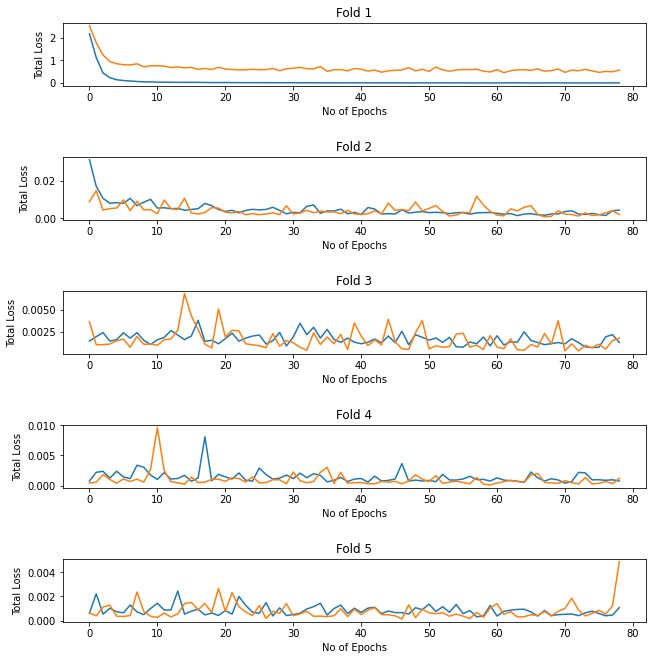

In [29]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_c, X_test_c, y_train, y_test)
end = time.time()
training_time = end - start

In [30]:
print(f"Time took to train {training_time} seconds")

Time took to train 59.30935549736023 seconds


In [31]:
def cf_matrix(y_pred, test_y):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)
  y_pred = y_pred.detach().numpy().ravel()
  correct_pred = (y_pred == test_y).astype(np.float)
  acc = correct_pred.sum()*100.0 / y_pred.shape[0]
  cm = confusion_matrix(test_y.ravel(), y_pred)
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f1 = 2*((precision*recall*1.0)/(precision+recall))
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  print(f"Accuracy: {acc:.2f}%")
  print(f"Precision: {precision:.2f}%")
  print(f"Recall: {recall:.2f}%")
  print(f"F1 score: {f1:.2f}%")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm,acc, recall, precision, f1


Accuracy: 96.91%
Precision: 97.32%
Recall: 96.85%
F1 score: 97.08%


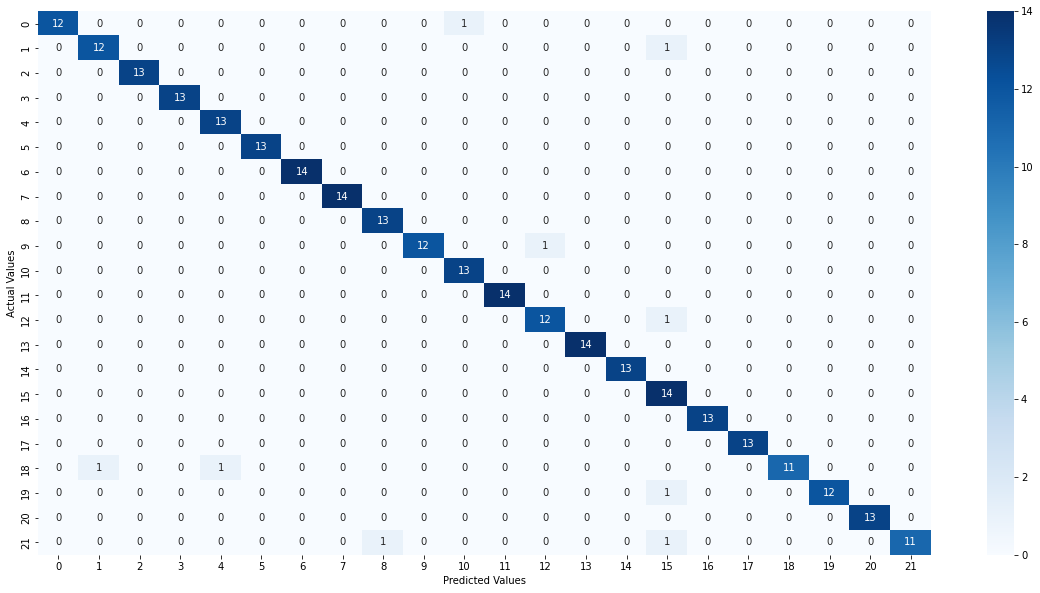

In [32]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [33]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(concat(acc,gyro)+DMM_Sobel, concat)_predictions.mat", pred_dict)

In [34]:
import datetime
ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'FF_CCA(concat(acc,gyro)+DMM_Sobel, concat)_DNN_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)

In [35]:
train_set, test_loader = train_test_loader(X_train_s, X_val_s, y_train, y_val)
inpsize = X_train_s.shape[1]
outsize = np.unique(y_train).shape[0]
dtype = torch.float
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.2], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [20, 100]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},    
        {"name": "max_epoch", "type": "range", "bounds": [10, 100]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]},     
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 02-08 06:30:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:30:50] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:30:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-08 06:30:50] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter di

{'lr': 0.000701018728556968, 'batchsize': 43, 'momentum': 0.3233100213662488, 'max_epoch': 75, 'stepsize': 30}
{'accuracy': 0.9028848076184971}
{'accuracy': {'accuracy': 0.0007544803006116805}}


In [37]:
best_parameters

{'lr': 0.000701018728556968,
 'batchsize': 43,
 'momentum': 0.3233100213662488,
 'max_epoch': 75,
 'stepsize': 30}

In [38]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

Training for fold 1
0.0
1.3333333333333333
2.6666666666666665
4.0
5.333333333333333
6.666666666666667
8.0
9.333333333333334
10.666666666666666
12.0
13.333333333333334
14.666666666666666
16.0
17.333333333333332
18.666666666666668
20.0
21.333333333333332
22.666666666666668
24.0
25.333333333333332
26.666666666666668
28.0
29.333333333333332
30.666666666666668
32.0
33.333333333333336
34.666666666666664
36.0
37.333333333333336
38.666666666666664
40.0
41.333333333333336
42.666666666666664
44.0
45.333333333333336
46.666666666666664
48.0
49.333333333333336
50.666666666666664
52.0
53.333333333333336
54.666666666666664
56.0
57.333333333333336
58.666666666666664
60.0
61.333333333333336
62.666666666666664
64.0
65.33333333333333
66.66666666666667
68.0
69.33333333333333
70.66666666666667
72.0
73.33333333333333
74.66666666666667
76.0
77.33333333333333
78.66666666666667
80.0
81.33333333333333
82.66666666666667
84.0
85.33333333333333
86.66666666666667
88.0
89.33333333333333
90.66666666666667
92.0
93.333

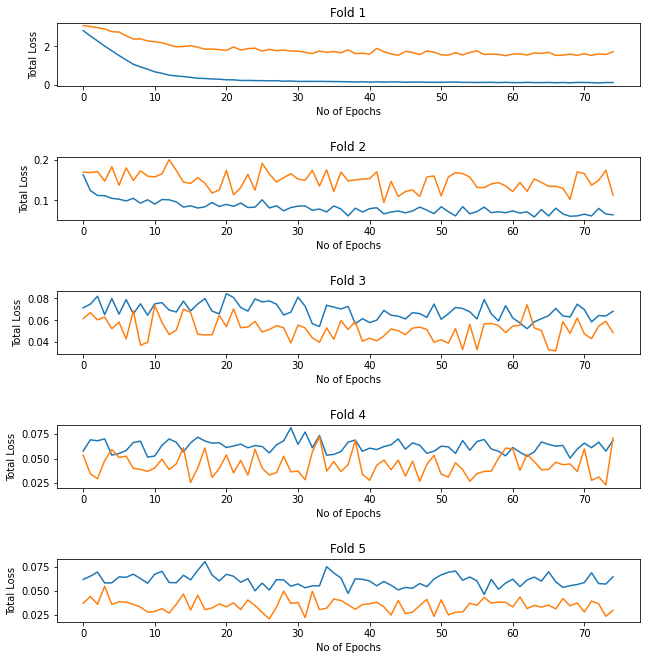

In [39]:
start = time.time()
best_model, y_pred = model_training_evaluation(X_train_c, X_test_c, y_train, y_test)
end = time.time()
training_time = end - start

In [40]:
print(f"Time took to train {training_time} seconds")

Time took to train 84.9865038394928 seconds


Accuracy: 90.38%
Precision: 90.67%
Recall: 90.38%
F1 score: 90.53%


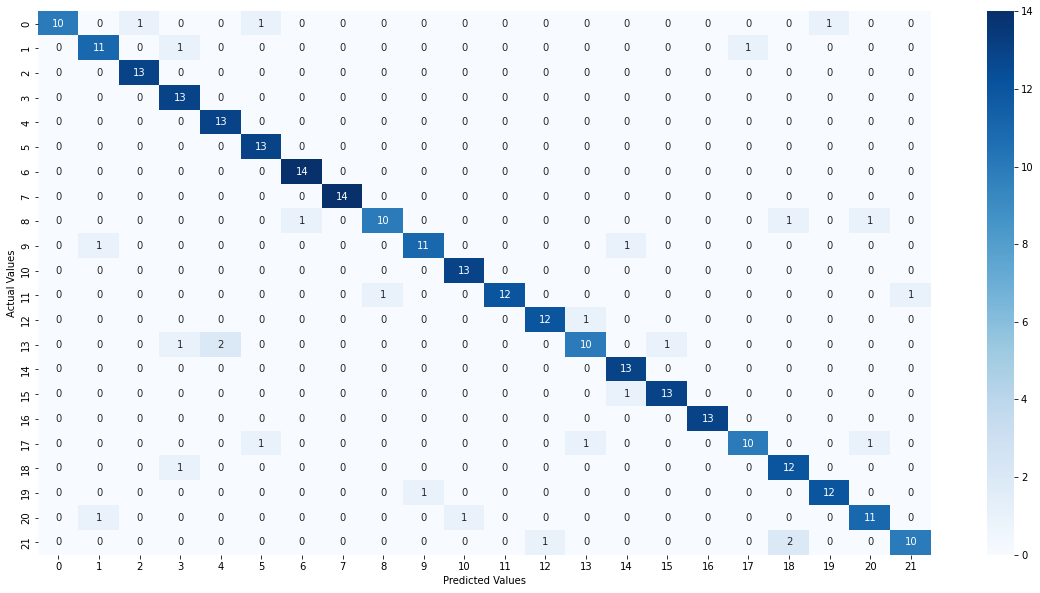

In [41]:
cm,acc, recall, precision,f1 = cf_matrix(y_pred, y_test)

In [42]:
pred_dict = {"preds":y_pred.detach().numpy(), 'y_test':y_test.ravel()}
sio.savemat("drive/My Drive/Dataset/Final Dataset/Predictions/FF_CCA(concat(acc,gyro)+DMM_Sobel, sum)_predictions.mat", pred_dict)

ts = str((datetime.datetime.now()).timestamp())
model_save_name = 'FF_CCA(concat(acc,gyro)+DMM_Sobel, sum)_DNN_'+ts+'_.pt'
path = F"drive/My Drive/Dataset/Final Dataset/Models/Feature Fusion/{model_save_name}" 
torch.save(best_model.state_dict(), path)